# 1️⃣ 가위바위보 분류기

### 😀 프로젝트 순서   

**1. 데이터 준비/전처리**   
**2. 모델 설계**   
**3. 모델 학습**   
**4. 모델 평가**   
**5. 모델 개선** 

## 1. 데이터 준비/전처리

1. https://teachablemachine.withgoogle.com/ 를 통해 직접 제작(테스트용 데이터 300장)
2. 위 사이트에서 만든 친구들의 데이터 모음(훈련용 데이터 4200장)
3. resize(), load_data()를 통한 데이터 전처리

#### resize() 함수 만들기
(해상도 조정)

In [4]:
from PIL import Image # Image모듈(open, resize, save 함수)
import os, glob #glob 모듈의 glob 함수

def resize_images(img_path):
    images=glob.glob(img_path + "/*.jpg")   # glob: 경로의 모든 파일 및 디렉토리를 리스트로 반환
    
    print(len(images), "images to be resized.")
    
    # 작은 해상도로 resizing 한 후 jpeg로 저장
    target_size=(28, 28)
    for img in images:
        old_img=Image.open(img)
        new_img=old_img.resize(target_size, Image.ANTIALIAS) # 안티엘리어싱
        new_img.save(img, "JPEG")
        
    print(len(images), "images resized.")

안티엘리어싱: 높은 해상도의 사진 또는 영상을 낮은 해상도로 변환하거나 나타낼때 깨진 패턴의 형태로 나타나게 되는데 이를 최소화 시켜주는 방법

In [16]:
image_dir_path = os.getenv('HOME') + '/aiffel/rsp/modu/sci'
resize_images(image_dir_path)

image_dir_path = os.getenv('HOME') + '/aiffel/rsp/modu/roc'
resize_images(image_dir_path)

image_dir_path = os.getenv('HOME') + '/aiffel/rsp/modu/pap'
resize_images(image_dir_path)

1400 images to be resized.
1400 images resized.
1400 images to be resized.
1400 images resized.
1400 images to be resized.
1400 images resized.


#### load_data() 함수 만들기   
(이미지 데이터화 및 라벨링)

In [17]:
import numpy as np

def load_data(img_path, number_of_data=4200):
    img_size=28
    color=3    
    # 이미지와 라벨 데이터를 담을 행렬(matrix) 생성
    imgs=np.zeros(number_of_data*img_size*img_size*color,dtype=np.int32).reshape(number_of_data,img_size,img_size,color)
    labels=np.zeros(number_of_data, dtype=np.int32)
    
    idx = 0
    for file in glob.iglob(img_path + '/sci/*.jpg'): #glob.iglob는 리스트 대신 이터레이터 반환
        img = np.array(Image.open(file), dtype=np.int32)
        imgs[idx,:,:,:] = img     # 데이터 영역에 이미지 행렬을 복사
        labels[idx] = 0 # 가위:0
        idx = idx + 1
        
    for file in glob.iglob(img_path+'/roc/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=1   # 바위:1
        idx=idx+1  
    
    for file in glob.iglob(img_path+'/pap/*.jpg'):
        img = np.array(Image.open(file),dtype=np.int32)
        imgs[idx,:,:,:]=img
        labels[idx]=2   # 보:2
        idx=idx+1
        
    return imgs, labels

#### 훈련용 데이터 확인

x_train shape: (4200, 28, 28, 3)
y_train shape: (4200,)
라벨:  0


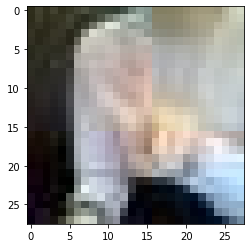

In [18]:
image_dir_path = os.getenv("HOME") + "/aiffel/rsp/modu"
(x_train, y_train)=load_data(image_dir_path)
x_train = x_train/255.0 # 입력을 0 ~ 1 사이의 값으로 정규화

print("x_train shape: {}".format(x_train.shape))
print("y_train shape: {}".format(y_train.shape))

import matplotlib.pyplot as plt
plt.imshow(x_train[1])
print('라벨: ', y_train[1])

#### 테스트용 데이터 확인

x_test shape: (300, 28, 28, 3)
y_test shape: (300,)
라벨:  0


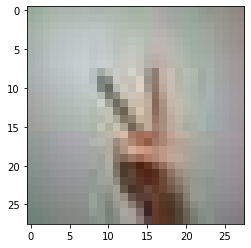

In [15]:
image_dir_path = os.getenv("HOME") + "/aiffel/rsp"
(x_test, y_test)=load_data(image_dir_path)
x_test = x_test/255.0

print("x_test shape: {}".format(x_test.shape))
print("y_test shape: {}".format(y_test.shape))

plt.imshow(x_test[1])
print('라벨: ', y_test[1])

---

## 2. 모델 설계

1. 케라스의 여러 모델 공부하기
2. 순차모델에서 레이어층 활용법 공부하기

In [19]:
from tensorflow import keras
import numpy as np

model=keras.models.Sequential() # 케라스의 순차모델. 순차적으로 레이어 층 더함
model.add(keras.layers.Conv2D(16, (3, 3), activation='relu', input_shape=(28, 28, 3))) # 입력이미지 형태
model.add(keras.layers.MaxPool2D(2, 2))
model.add(keras.layers.Conv2D(32, (3, 3), activation='relu')) # 16, 32 등 얼마나 다양한 이미지 특징을 살펴볼 것인가 나타냄
model.add(keras.layers.MaxPooling2D((2, 2)))
model.add(keras.layers.Flatten()) # 1차원으로 나열
model.add(keras.layers.Dense(32, activation='relu')) # 분류기 알고리즘 얼마나 복잡하게 할것인가 나타냄 (32, 64, 128 등)
model.add(keras.layers.Dense(3, activation='softmax')) # 최종 분류기의 class 수 (숫자는 10, 알파벳은 52 등 결과에 따라 바뀜)

print("Model에 추가된 Layer 개수:", len(model.layers))

model.summary()

Model에 추가된 Layer 개수: 7
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 16)        448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 16)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 32)        4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 800)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                25632     
_________________________________________________________________
dense_1 (Dense)              (Non

---

## 3. 모델 학습

1. 첫 번째 레이어 층에서 input_shape=(28,28,3)로 지정했던 것을 전처리과정에서의 형태(데이터갯수, 이미지 크기 x, 이미지 크기 y, 채널수)로 바꿔줘야함   
2. compile(), fit()를 통한 학습 진행
  - 옵티마이저(Optimizer): 데이터와 손실 함수를 바탕으로 모델의 업데이트 방법을 결정
  - 손실 함수(Loss function): 훈련 하는 동안 모델의 오차를 측정. 모델의 학습이 올바른 방향으로 향하려면 이 함수를 최소화해야함.
  - 지표(Metrics): 훈련 단계와 테스트 단계를 모니터링하기 위해 사용.

In [23]:
x_train_reshaped=x_train.reshape( -1, 28, 28, 3)

model.compile(optimizer='adam', # 기울기 방향에 대한 경사하강 방법(역전파를 통한 가중치 최적화)
              loss='sparse_categorical_crossentropy', # 다중 분류의 Cross Entropy Error
              metrics=['accuracy']) # 모델 평가를 위한 평가 지표
model.fit(x_train_reshaped, y_train, epochs=10)  # epochs:학습 반복 횟수

Epoch 1/10
132/132 [==============================] - 1s 3ms/step - loss: 0.0569 - accuracy: 0.9874
Epoch 2/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0389 - accuracy: 0.9939
Epoch 3/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0266 - accuracy: 0.9961
Epoch 4/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0207 - accuracy: 0.9967
Epoch 5/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0303 - accuracy: 0.9926
Epoch 6/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0133 - accuracy: 0.9976
Epoch 7/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0161 - accuracy: 0.9976
Epoch 8/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0087 - accuracy: 0.9988
Epoch 9/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0055 - accuracy: 0.9980
Epoch 10/10
132/132 [==============================] - 0s 3ms/step - loss: 0.0036 - accuracy: 0.9999

---

## 4. 모델 평가

evaluate()를 통해 평가

In [24]:
model.evaluate(x_test, y_test, verbose=2) # verbose 0,1,2 가능

10/10 - 1s - loss: 1.3041 - accuracy: 0.6967


[1.3041162490844727, 0.6966666579246521]

---

## 5. 모델 개선

**테스트 결과** <br>  
학습데이터(내 데이터) **300장** / 테스트데이터(친구 데이터) **300장** 으로 테스트 시 정확도 **약 0.46**을 얻음   
기준점에 미달하여 개선 시도<br>


**개선 방안**
1. 하이퍼파라미터 튜닝
  - 정규화 제거 -> 정확도 **약 0.49**로 상승 -> 하지만 loss 값이 600으로 폭증함
  - Conv2D 레이어의 이미지 특징 수를 2배로 늘림 -> 정확도 **약 0.33**으로 감소 -> 해당 파라미터를 높이자 오히려 정확도가 감소함 
  - Dense 레이어의 뉴런 수 2배로 늘림 -> 정확도 **약 0.35**으로 감소 ->  마찬가지로 파라미터를 높이자 정확도 감소함

**해당 케이스의 경우 하이퍼파라미터 튜닝으로 정확도를 상승시키기는 어렵다고 판단함**

2. 학습데이터 늘리기
  - 내 데이터(학습용) **300장** / 친구 데이터(테스트용) **300장** -> 친구들 데이터(학습용) **4200장** / 내 데이터(테스트용) **300장**


### 위와 같이 정확도 약 0.7로 기준점(0.6) 이상 도달